In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice

In [3]:
from surp.src.analysis.vice_model import vice_model
from surp.src.analysis import apogee_analysis as aah
import arya

arya.save_at("./figures")


In [4]:
plt.rcParams["figure.dpi"] = 200

In [5]:
width = 4
ϕ = np.sqrt(2)
height = width/ϕ
arya.style.set_size((width, height))


In [6]:
fiducial = vice_model("../output/C11_f0.2_eta1_beta0.001.json")

one file saved at ./figures/cooh_scatter.pdf


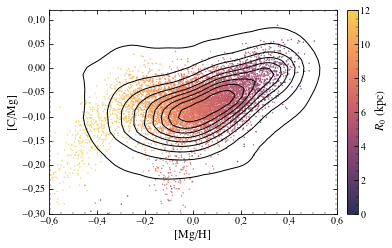

In [7]:
s = fiducial.stars["solar"]

N = len(s)
dx = 0.03
dy = 0.03
sp = arya.Subplot()
aah.plot_contour("[mg/h]", "[c/mg]", ax=sp.mpl_ax, zorder=3)

scat = arya.Scatter(s["[o/h]"] + np.random.normal(0, dx, N), s["[c/o]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2, subplot=sp)
scat.clim = (0, 12)
cb = arya.Colorbar(subplot=sp, layer=scat, row=0, col=1, width=arya.Length(0.05*height))
cb.label = "$R_0$ (kpc)"


sp.x.label=r"[Mg/H]"
sp.y.label=r"[C/Mg]"
sp.x.lim=(-0.6, 0.6)
sp.y.lim=(-0.3, 0.12)

sp.save("cooh_scatter.pdf")

one file saved at ./figures/cnoh_scatter.pdf


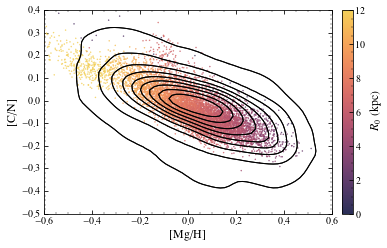

In [8]:
N = len(s)
dx = 0.03
dy = 0.03
sp = arya.Subplot()
aah.plot_contour("[mg/h]", "[c/n]", ax=sp.mpl_ax, zorder=3)
aah.plot_contour("[mg/h]", "[c/n]", ax=sp.mpl_ax, zorder=3)

scat = arya.Scatter(s["[o/h]"] + np.random.normal(0, dx, N), s["[c/n]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2, subplot=sp)
scat.clim = (0, 12)
cb = arya.Colorbar(subplot=sp, layer=scat, row=0, col=1,  width=arya.Length(0.05*height))
cb.label = "$R_0$ (kpc)"


sp.x.label=r"[Mg/H]"
sp.y.label=r"[C/N]"
sp.x.lim=(-0.6, 0.6)
sp.y.lim=(-0.5, 0.4)

sp.save("cnoh_scatter.pdf")

In [18]:
vice.yields.ccsne.settings["c"]

0.00236

one file saved at ./figures/evo_tracks.pdf


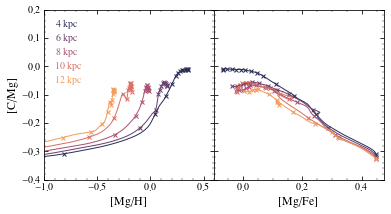

In [14]:
jp = arya.JoinPlot(1, 2)

sp = jp.children[0][0]

fiducial.plot_R_slices("[o/h]", "[c/o]", ax=sp.mpl_ax)

sp.x.label = r"[Mg/H]"
sp.y.label = r"[C/Mg]"
sp.x.lim = (-1, 0.6)
sp.y.lim = (-0.4, 0.2)


sp = jp.children[0][1]

fiducial.plot_R_slices("[o/fe]", "[c/o]", ax=sp.mpl_ax, legend=False)
sp.x.label = r"[Mg/Fe]"
sp.y.label = r""

sp.save("evo_tracks.pdf")

one file saved at ./figures/evo_slices.pdf


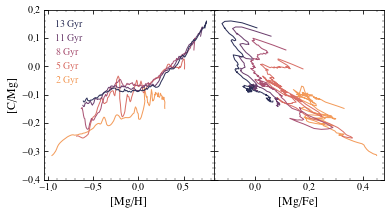

In [13]:
s = fiducial.stars["solar"]
N = len(s)
dx = 0.03
dy = 0.03

jp = arya.JoinPlot(1, 2)

sp = jp.children[0][0]

fiducial.plot_t_slices("[o/h]", "[c/o]", ax=sp.mpl_ax)

sp.x.label = r"[Mg/H]"
sp.y.lim = (-0.4, 0.2)
sp.y.label = r"[C/Mg]"

sp = jp.children[0][1]


fiducial.plot_t_slices("[o/fe]", "[c/o]", ax=sp.mpl_ax, legend=False)
sp.x.label = r"[Mg/Fe]"
sp.y.label = r""
sp.save("evo_slices.pdf")